## Adding Noise to the audio dataset and creating Spectrograms for noise added data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile

def create_spectrogram(audio_path, output_directory, add_noise=True, noise_level=0.005):
    try:
        # Read the WAV file
        sample_rate, audio_data = wavfile.read(audio_path)

        # Add noise if specified
        if add_noise:
            noise = np.random.normal(0, noise_level, audio_data.shape)
            noise = noise.astype(audio_data.dtype)  # Convert noise to the same data type as audio_data
            audio_data += noise

        # Create spectrogram
        Pxx, freqs, bins, im = plt.specgram(audio_data, NFFT=1024, Fs=8000, noverlap=900)
        plt.axis('off')

        if not os.path.exists(output_directory):
            os.makedirs(output_directory)

        # Save the spectrogram as an image
        output_filename = os.path.join(output_directory, os.path.splitext(os.path.basename(audio_path))[0] + '_spectrogram.png')
        plt.savefig(output_filename, bbox_inches='tight')
        plt.close()  # Close the figure to release resources

    except ValueError as ve:
        print(f"Error during spectrogram computation for {audio_path}: {ve}")

def process_data(data_folder, output_base_directory, add_noise=True, noise_level=0.005):
    res = []
    clss = []
    count = 0

    for root, dirs, files in os.walk(data_folder):
        for file in files:
            audio_path = os.path.join(root, file)

            # Check if the file is a WAV file
            if audio_path.lower().endswith('.wav'):
                class_label = os.path.relpath(root, data_folder)  # Use the relative path from data_folder as the class label
                res.append(audio_path)
                clss.append(class_label)

                # Generate spectrogram with or without noise
                output_directory = os.path.join(output_base_directory, class_label)
                create_spectrogram(audio_path, output_directory, add_noise=add_noise, noise_level=noise_level)

                count += 1
                print(count, end='/')

    df = pd.DataFrame({'Path': res, 'Class': clss})
    return df


In [5]:
data_folder = 'Data/Audio/'
output_base_directory = 'Spectrograms_noise/'

df = process_data(data_folder, output_base_directory,noise_level=0.008)
df.head()

1/2/3/4/5/6/7/8/9/10/11/12/13/14/15/16/17/18/19/20/21/22/23/24/25/26/27/28/29/30/31/32/33/34/35/36/37/38/39/40/41/42/43/44/45/46/47/48/49/50/51/52/53/54/55/56/57/58/59/60/61/62/63/64/65/66/67/68/69/70/71/72/73/74/75/76/77/78/79/80/81/82/83/84/85/86/87/88/89/90/91/92/93/94/95/96/97/98/99/100/101/102/103/104/105/106/107/108/109/110/111/112/113/114/115/116/117/118/119/120/121/122/123/124/125/126/127/128/129/Error during spectrogram computation for Data/Audio/Female\TMIT\SI1160.wav: operands could not be broadcast together with shapes (1024,2,1870) (1024,1) 
130/131/Error during spectrogram computation for Data/Audio/Female\TMIT\SI1208.wav: operands could not be broadcast together with shapes (1024,2,1089) (1024,1) 
132/133/134/135/136/137/138/139/140/141/142/143/144/145/146/147/148/149/150/151/152/153/154/155/156/Error during spectrogram computation for Data/Audio/Female\TMIT\SI1790.wav: operands could not be broadcast together with shapes (1024,2,821) (1024,1) 
157/158/Error during spect

,Path,Class
0,Data/Audio/Female\PTDB-TUG\mic_F01_sa2.wav,Female\PTDB-TUG
1,Data/Audio/Female\PTDB-TUG\mic_F01_si454.wav,Female\PTDB-TUG
2,Data/Audio/Female\PTDB-TUG\mic_F01_si473.wav,Female\PTDB-TUG
3,Data/Audio/Female\PTDB-TUG\mic_F01_si502.wav,Female\PTDB-TUG
4,Data/Audio/Female\PTDB-TUG\mic_F01_si523.wav,Female\PTDB-TUG


## Building Model on the noises added spectograms with agumentation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchaudio
from torchaudio.transforms import AddNoise, TimeMasking, TimeStretch
import matplotlib.pyplot as plt
from torch.autograd import Variable
from scipy.io import wavfile
from PIL import Image
import io
from torchvision import transforms

In [2]:

def get_data_loaders(data_root, batch_size=64, augmentation=True):
    # Define basic transformations
    basic_transforms = [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]

    if augmentation:
        additional_transforms = [
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        ]
        transform = transforms.Compose(basic_transforms + additional_transforms)
    else:
        transform = transforms.Compose(basic_transforms)

    # Create dataset
    dataset = ImageFolder(root=data_root, transform=transform)

    # Split dataset into train and validation sets
    train_size = int(0.80 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, dataset

In [21]:
# Neural network model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 16 * 16, num_classes)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        return x

In [22]:
# Training and evaluation functions
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total_samples += labels.size(0)
        correct_predictions += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total_samples += labels.size(0)
            correct_predictions += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy


In [23]:
# Training loop with added plotting
def train_loop_with_plotting(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training
        train_loss, train_accuracy = train_model(model, train_loader, optimizer, criterion, device)

        # Validation
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)

        scheduler.step()  # Step the learning rate scheduler

        # Append losses and accuracies for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print training and validation results for the epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')

    # Plotting
    plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)

    
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch [1/20], Training Loss: 2.5340, Training Accuracy: 0.34, Validation Loss: 1.3341, Validation Accuracy: 0.27
Epoch [2/20], Training Loss: 1.7193, Training Accuracy: 0.40, Validation Loss: 1.0050, Validation Accuracy: 0.55
Epoch [3/20], Training Loss: 1.3514, Training Accuracy: 0.46, Validation Loss: 0.9885, Validation Accuracy: 0.43
Epoch [4/20], Training Loss: 1.2781, Training Accuracy: 0.51, Validation Loss: 0.8031, Validation Accuracy: 0.66
Epoch [5/20], Training Loss: 1.0563, Training Accuracy: 0.57, Validation Loss: 0.6743, Validation Accuracy: 0.64
Epoch [6/20], Training Loss: 1.0392, Training Accuracy: 0.58, Validation Loss: 0.9121, Validation Accuracy: 0.70
Epoch [7/20], Training Loss: 1.1256, Training Accuracy: 0.54, Validation Loss: 0.7105, Validation Accuracy: 0.68
Epoch [8/20], Training Loss: 0.8697, Training Accuracy: 0.64, Validation Loss: 0.6631, Validation Accuracy: 0.73
Epoch [9/20], Training Loss: 0.9036, Training Accuracy: 0.62, Validation Loss: 0.6364, Validatio

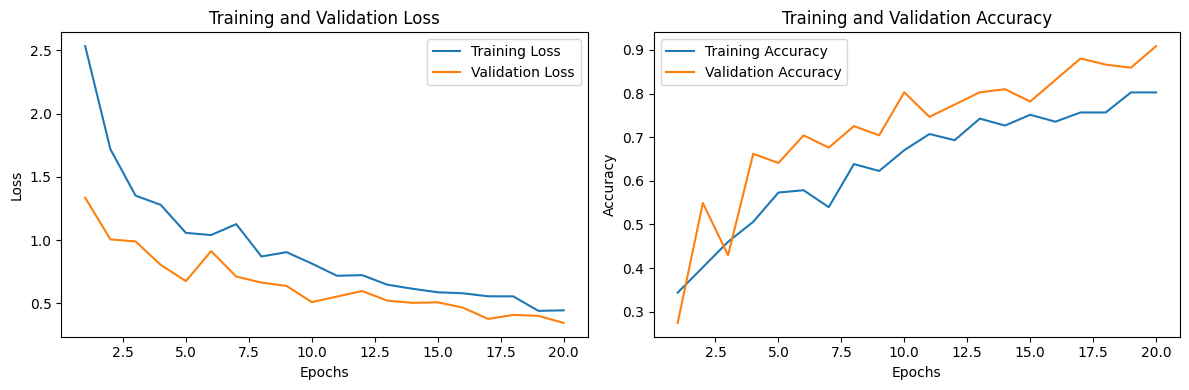

In [25]:
data_root = 'Spectrograms_noise - Copy'
train_loader, val_loader, dataset = get_data_loaders(data_root, noise_level=0.005)

model = SimpleCNN(num_classes=9)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

num_epochs = 20
train_loop_with_plotting(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device)


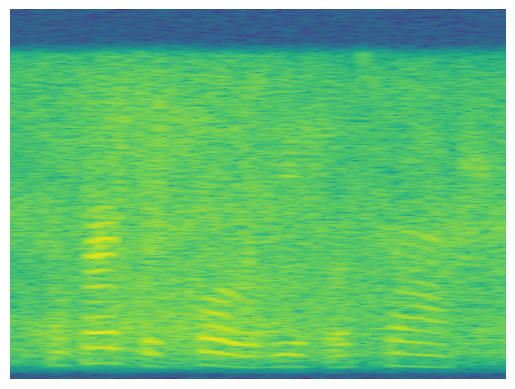

The predicted class is: Street


In [29]:
from torch.utils.data import Dataset
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

class AudioDataset(Dataset):
    def __init__(self, audio_file, transform=None):
        self.audio_file = audio_file
        self.transform = transform

    def __len__(self):
        return 1  # Since we have only one audio file

    def __getitem__(self, idx):
        sample_rate, audio_data = wavfile.read(self.audio_file)
        return audio_data, sample_rate

# Function to generate and show spectrogram image
def generate_and_show_spectrogram(audio_data, sample_rate):
    plt.specgram(audio_data, NFFT=1024, Fs=sample_rate, noverlap=900)
    plt.axis('off')
    plt.show()

# Function to make prediction
def predict_class(model, image, transform):
    image_tensor = transform(image)
    image_tensor = Variable(image_tensor.unsqueeze(0))
    
    with torch.no_grad():
        outputs = model(image_tensor)
    
    probabilities = nn.Softmax(dim=1)(outputs)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    
    return predicted_class

# Main part
if __name__ == "__main__":
    audio_file = 'Data/Audio/Noizeus/Street/sp03_street_sn5.wav'

    audio_dataset = AudioDataset(audio_file, transform=None)
    audio_data, sample_rate = audio_dataset[0]

    # Generate and show spectrogram image
    generate_and_show_spectrogram(audio_data, sample_rate)
    image_tensor = transform(Image.fromarray(audio_data).convert('RGB'))
    image_tensor = Variable(image_tensor.unsqueeze(0))
    
    with torch.no_grad():
        outputs = model(image_tensor)
    
    probabilities = nn.Softmax(dim=1)(outputs)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    # Get the class label
    class_label = dataset.classes[predicted_class]

    print(f'The predicted class is: {class_label}')

In [30]:
torch.save(model.state_dict(), 'model/voice_noise.pth')